In [7]:
from matplotlib import pyplot as plt

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
import numpy as np

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
class GAN(object):
    def __init__(self, img_width, img_height, img_channels, DM_optimizer = RMSprop(lr = 0.0002, decay = 6e-8),\
                 AM_optimizer = RMSprop(lr = 0.0001, decay = 3e-8), print_summary = False):
        
        self.input_shape = (img_width, img_height, img_channels)
        self.input_noice_dim = 100
        
        if print_summary:
            print("Generator:")
        self.Gen = self.__generator(print_summary)
        
        if print_summary:
            print("\nDiscriminator:")
        self.Dis = self.__discriminator(print_summary)
        
        if print_summary:
            print("\nDM:")
        self.DM = self.__dm(DM_optimizer, print_summary)
        
        if print_summary:
            print("\nAM:")
        self.AM = self.__am(AM_optimizer, print_summary)
        
    def __generator(self, print_summary = False):
        g = Sequential()
        dropout = 0.5
        depth = 256
        dim = int(self.input_shape[0] / 4)
        
        g.add(Dense(dim * dim * depth, input_dim = self.input_noice_dim))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        g.add(Reshape((dim, dim, depth)))
        g.add(Dropout(dropout))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 2), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 4), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(Conv2DTranspose(int(depth / 8), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.99))
        g.add(LeakyReLU(alpha = 0.2))
        
        g.add(Conv2DTranspose(self.input_shape[2], 5, padding = 'same'))
        g.add(Activation('tanh')) #tu był sigmoid
        
        if print_summary:
            g.summary()

        return g
    
    def __discriminator(self, print_summary = False):
        d = Sequential()
        dropout = 0.5
        depth = 64
        
        d.add(Conv2D(depth * 1, 5, strides = 2, input_shape = self.input_shape, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 2, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 4, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 8, 5, strides = 1, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Flatten())
        d.add(Dense(1))
        d.add(Activation('sigmoid'))
        
        if print_summary:
            d.summary()
            
        return d
    
    def __dm(self, optimizer, print_summary = False):
        self.Dis.trainable = True
        dm = Sequential()
        dm.add(self.Dis)
        
        if print_summary:
            dm.summary()
        
        dm.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return dm
    
    def __am(self, optimizer, print_summary = False):
        #Freezing Discriminator weights during the generator adversarial training
        self.Dis.trainable = False
        am = Sequential()
        am.add(self.Gen)
        am.add(self.Dis)
        
        if print_summary:
            am.summary()
        
        am.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return am
    
    def train(self, steps, batch_size, real_imgs, info_rate = 10):
        for i in range(steps):
            r = real_imgs[np.random.randint(0, real_imgs.shape[0], size = batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size = [batch_size, self.input_noice_dim])
            f = self.Gen.predict(noise)
            x = np.concatenate((r, f))
            y = np.ones([2 * batch_size, 1])
            y[batch_size:, :] = 0
            dm_loss = self.DM.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.input_noice_dim])
            am_loss = self.AM.train_on_batch(noise, y)
            
            if i % info_rate == 0:
                print("Step:", i, "DM loss:", dm_loss, "AM loss:", am_loss)

In [9]:
import helper
from glob import glob
import os

In [10]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join('.', 'img_align_celeba/*.jpg')))
print(celeba_dataset.shape)

(202599, 28, 28, 3)


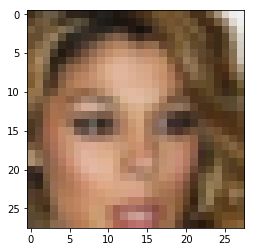

In [12]:
images = next(celeba_dataset.get_batches(celeba_dataset.shape[0]))
image_scaled = images[5]
image_scaled = (((image_scaled - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
plt.imshow(image_scaled)

In [13]:
learning_rate = 0.00025
beta1 = 0.45

face_cnn = GAN(28, 28, 3, DM_optimizer = Adam(lr = learning_rate, beta_1 = beta1),\
               AM_optimizer = Adam(lr = learning_rate, beta_1 = beta1), print_summary = True)

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    

In [ ]:
face_cnn.train(30000, 64, images, 1000)

Step: 0 DM loss: [0.6399895, 0.5859375] AM loss: [0.8643421, 0.265625]
Step: 1000 DM loss: [0.63973486, 0.5703125] AM loss: [0.90488046, 0.28125]


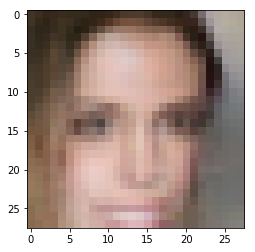

In [162]:
noise = np.random.uniform(-1.0, 1.0, size = [1, face_cnn.input_noice_dim])
i = face_cnn.Gen.predict(noise)
i = (((i - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
plt.imshow(i[0])

In [430]:
import tensorflow as tf

In [ ]:
image_upsampled = tf.keras.backend.resize_images(image_scaled.reshape([1, 28, 28, 3]), 4, 4, "channels_last")
print(image_upsampled.shape)
print(image_upsampled)
plt.imshow(tf.to_float(image_upsampled[0]))

In [ ]:
us = Upsampler(4)

image_upsampled = us.upsample(image_scaled.reshape([1, 28, 28, 3]))
print(image_upsampled.shape)
plt.imshow(image_upsampled[0])